In [2]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import corner
from jnkepler.jaxttv import jaxttv, elements_to_pdic, params_to_elements
from jax.config import config
import numpyro, jax
config.update('jax_enable_x64', True)
numpyro.set_host_device_count(4)
print ('# jax device count:', jax.local_device_count())

# jax device count: 4


In [3]:
npl = 5
datadir = "./toi1136/toi1136_fei/"
import glob

In [4]:
tcobs, errorobs, p_init = [], [], []
for i in range(npl):
    fname = glob.glob(datadir + "*_planet%d_ephemeris.txt"%(i))[0]
    tnum, tc, tcerr = np.array(pd.read_csv(fname, delim_whitespace=True)).T
    tcobs.append(tc)
    errorobs.append(tcerr)
    p, t0 = np.polyfit(tnum, tc, deg=1)
    p_init.append(p)
p_init = np.array(p_init)

In [5]:
import itertools
tclist = list(itertools.chain.from_iterable(tcobs))
print (p_init[0])
print (np.min(tclist), np.max(tclist))

4.171819802773315
1684.2853159306617 2650.0309951


In [6]:
dt = 0.1
t_start, t_end = 1680, 2655
jttv = jaxttv(t_start, t_end, dt)

In [7]:
jttv.set_tcobs(tcobs, p_init, errorobs=errorobs)

# integration starts at:           1680.00
# first transit time in data:      1684.29
# last transit time in data:       2650.03
# integration ends at:             2655.00
# integration time step:           0.1000 (1/41 of innermost period)


In [8]:
outdir = "toi1136/test_"
outdir = "toi1136/test_4chains_"

initial objective function: 13592.62 (69 data)

running LM optimization...
objective function: 272.77 (69 data)
# elapsed time (least square): 28.5 sec


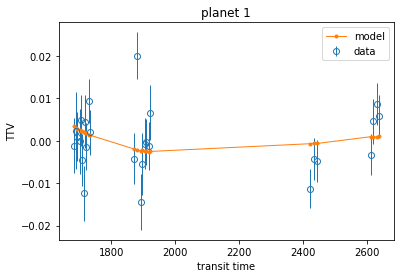

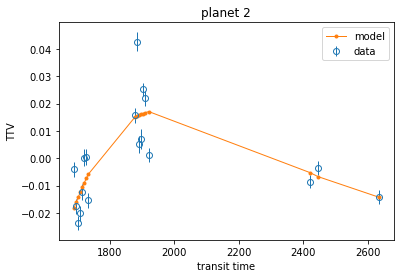

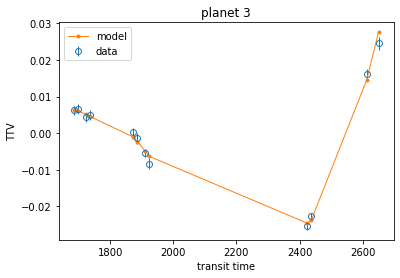

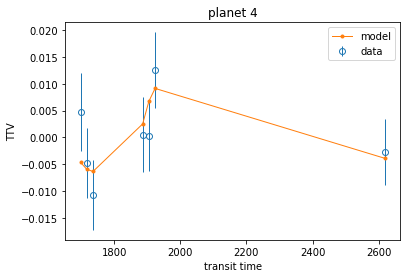

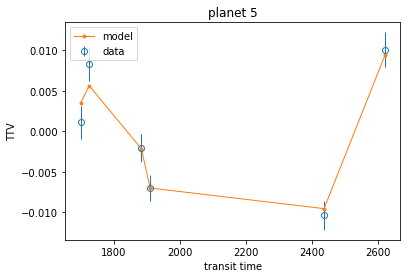

In [9]:
params_best = jttv.optim(amoeba=False, mmax=1e-4, emax=0.1, save=outdir+"_ql")

In [10]:
tc, de = jttv.get_ttvs(*params_to_elements(params_best, jttv.nplanet))
print ("energy error:", de)

energy error: 1.0368751144129718e-05


In [11]:
%timeit jttv.get_ttvs(*params_to_elements(params_best, jttv.nplanet))

29.5 ms ± 374 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
pdic = pd.DataFrame(elements_to_pdic(*params_to_elements(params_best, jttv.nplanet)))
print (pdic)

      pmass     period     ecosw     esinw  cosi  lnode          tic  \
0  2.570285   4.171730 -0.003847  0.008162   0.0    0.0  1684.289823   
1  0.429945   6.258562  0.021719  0.014690  -0.0    0.0  1688.723231   
2  0.166940  12.518338 -0.009705  0.045171  -0.0    0.0  1686.067592   
3  2.362271  18.804406  0.026015 -0.099977   0.0    0.0  1697.760805   
4  2.489765  26.314449 -0.010854 -0.018004   0.0    0.0  1699.387041   

        ecc     omega     lnmass          mass      cosw      sinw  
0  0.009023  2.011274 -11.771719  7.719825e-06 -0.384734  0.816214  
1  0.026220  0.594710 -13.559834  1.291335e-06  0.828311  0.560269  
2  0.046202  1.782440 -14.505857  5.014023e-07 -0.210067  0.977687  
3  0.103307 -1.316232 -11.856113  7.095055e-06  0.251824 -0.967773  
4  0.021023 -2.113345 -11.803548  7.477981e-06 -0.516320 -0.856396  


In [13]:
pdic_init = elements_to_pdic(*params_to_elements(params_best, jttv.nplanet), outkeys=['period', 'ecc', 'cosw', 'sinw', 'cosi', 'lnode', 'tic', 'lnmass', 'mass'])
tic_guess = jnp.array([_tcobs[0] for _tcobs in jttv.tcobs])
p_guess = jnp.array(p_init)
ones = jnp.ones_like(p_guess)

In [14]:
from numpyro.infer import init_to_value
import numpyro.distributions as dist
import jax.random as random

def model(dp=5e-1, dtic=1e-1, emax=0.5, mmin=1e-7, mmax=1e-3, uniform_mass=False):
    tic = numpyro.sample("tic", dist.Uniform(low=tic_guess-dtic, high=tic_guess+dtic))
    period = numpyro.sample("period", dist.Uniform(low=p_guess-dp, high=p_guess+dp))
    ecc = numpyro.sample("ecc", dist.Uniform(low=ones*0, high=ones*emax))

    cosw = numpyro.sample("cosw", dist.Normal(scale=ones))
    sinw = numpyro.sample("sinw", dist.Normal(scale=ones))
    omega = jnp.arctan2(sinw, cosw)
    numpyro.deterministic("omega", omega)

    lnode = ones * 0
    numpyro.deterministic("lnode", lnode)
    cosi = ones * 0
    numpyro.deterministic("cosi", cosi)
    if uniform_mass:
        mass = numpyro.sample("mass", dist.Uniform(low=ones*mmin, high=ones*mmax))
        numpyro.deterministic("lnmass", jnp.log(mass))
    else:
        lnmass = numpyro.sample("lnmass", dist.Uniform(low=ones*jnp.log(mmin), high=ones*jnp.log(mmax)))
        mass = jnp.exp(lnmass)
        numpyro.deterministic("mass", mass)

    elements = jnp.array([period, ecc*cosw, ecc*sinw, cosi, lnode, tic]).T
    numpyro.deterministic("elements", elements)

    #tcmodel, ediff = jttv.get_ttvs_hermite4(elements, jnp.hstack([1, mass]))
    tcmodel, ediff = jttv.get_ttvs(elements, jnp.hstack([1., mass]))
    lntcjitter = numpyro.sample("lntcjitter", dist.Uniform(low=-8, high=-2))
    tcjitter = numpyro.deterministic("tcjitter", jnp.exp(lntcjitter))
    tcerrmodel = jnp.sqrt(jttv.errorobs_flatten**2 + tcjitter**2)
    numpyro.deterministic("ediff", ediff)
    numpyro.deterministic("tcmodel", tcmodel)
    numpyro.sample("obs", dist.Normal(loc=tcmodel, scale=tcerrmodel), obs=jttv.tcobs_flatten)

In [15]:
pdic_init['lntcjitter'] = -4.8
init_strategy = init_to_value(values=pdic_init)
pdic_init

{'period': DeviceArray([ 4.17173046,  6.25856232, 12.5183378 , 18.80440583,
              26.31444875], dtype=float64),
 'cosi': DeviceArray([ 0., -0., -0.,  0.,  0.], dtype=float64),
 'lnode': DeviceArray([0., 0., 0., 0., 0.], dtype=float64),
 'tic': DeviceArray([1684.28982346, 1688.72323088, 1686.06759194, 1697.76080478,
              1699.38704124], dtype=float64),
 'ecc': DeviceArray([0.00902345, 0.02622023, 0.04620181, 0.10330665, 0.02102265],            dtype=float64),
 'lnmass': DeviceArray([-11.77171889, -13.55983386, -14.50585702, -11.85611251,
              -11.80354766], dtype=float64),
 'mass': DeviceArray([7.71982480e-06, 1.29133517e-06, 5.01402324e-07,
              7.09505489e-06, 7.47798146e-06], dtype=float64),
 'cosw': DeviceArray([-0.38473437,  0.82831078, -0.21006713,  0.2518235 ,
              -0.51632035], dtype=float64),
 'sinw': DeviceArray([ 0.81621418,  0.56026892,  0.97768696, -0.96777318,
              -0.85639553], dtype=float64),
 'lntcjitter': -4.8}

In [17]:
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.8, init_strategy=init_strategy)

In [18]:
nw, ns = 100, 100 # 9h 30min
nw, ns = 500, 500 

In [ ]:
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)

In [19]:
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns, num_chains=4, progress_bar=False)

In [ ]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, extra_fields=('potential_energy',), mmin=0, mmax=1e-4, uniform_mass=True)

In [61]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
     cosw[0]     -0.51      0.04     -0.51     -0.56     -0.42      7.80      1.04
     cosw[1]      0.84      0.03      0.84      0.79      0.89      6.80      1.36
     cosw[2]     -0.14      0.05     -0.13     -0.21     -0.06      7.61      1.00
     cosw[3]      0.30      0.03      0.31      0.25      0.34      6.99      1.07
     cosw[4]     -0.61      0.08     -0.60     -0.70     -0.48      3.36      1.85
      ecc[0]      0.01      0.00      0.01      0.01      0.01      5.90      1.33
      ecc[1]      0.03      0.00      0.03      0.02      0.03      4.49      1.56
      ecc[2]      0.05      0.00      0.05      0.05      0.06      6.68      1.42
      ecc[3]      0.10      0.01      0.10      0.10      0.11      6.23      0.99
      ecc[4]      0.03      0.00      0.03      0.02      0.03      8.23      1.14
  lntcjitter     -4.92      0.08     -4.91     -5.06     -4.81      3.00      2.37
   

In [63]:
import dill
with open(outdir+"mcmc.pkl", "wb") as f:
    dill.dump(mcmc, f)

In [64]:
samples = mcmc.get_samples()

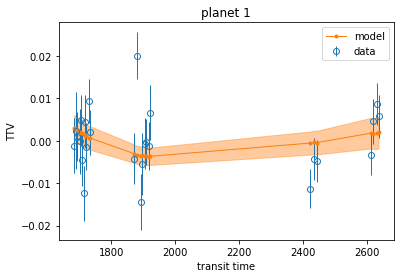

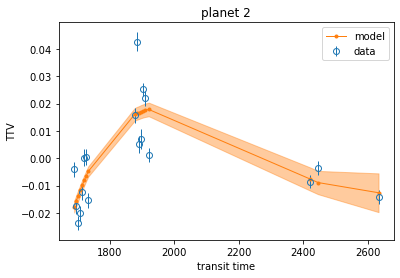

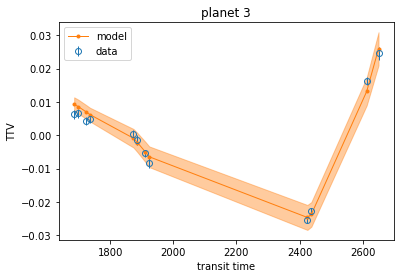

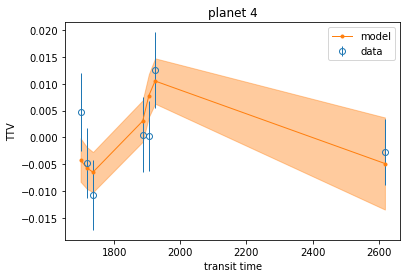

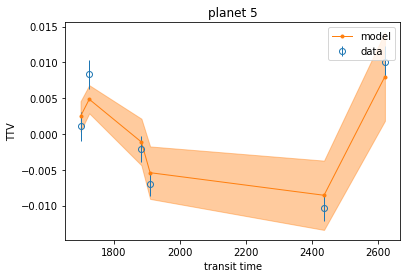

In [66]:
idx = samples['ediff']==samples['ediff']
mmodel, smodel = jnp.mean(samples['tcmodel'][idx], axis=0), jnp.std(samples['tcmodel'][idx], axis=0)
jttv.quicklook(mmodel, sigma=smodel, save=outdir+"postm")

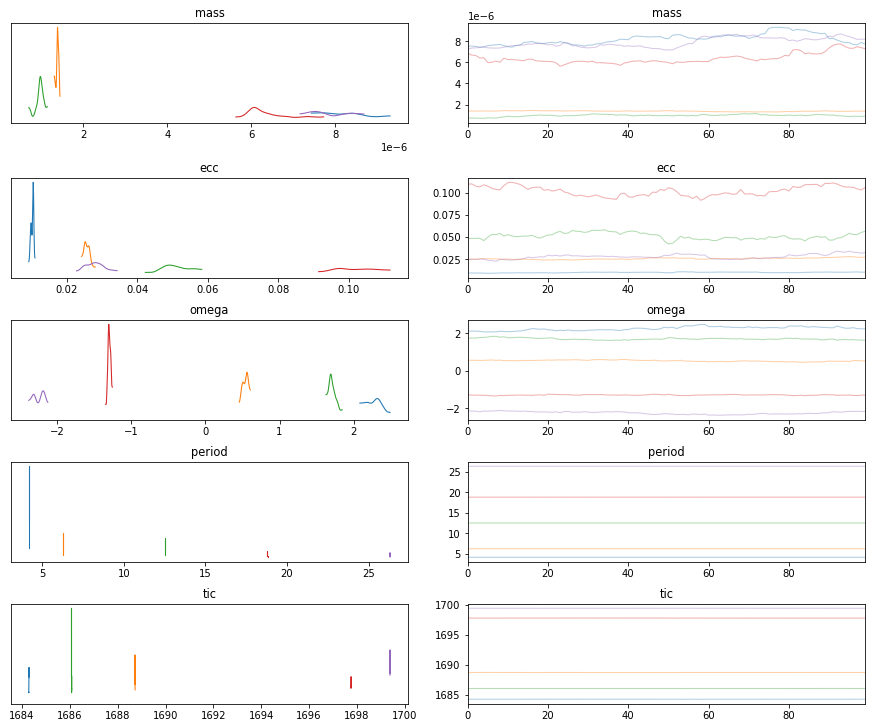

In [67]:
import arviz
fig = arviz.plot_trace(mcmc, var_names=['mass', 'ecc', 'omega', 'period', 'tic'])

0.007354935517399485 0.7354935517399486 0.00574743416005275 0.0090591922161486
0.010301693994523471 1.030169399452347 0.00276885234983865 0.0036712094640136
0.0017462300388759499 0.17462300388759497 0.00125306703595325 0.00183
0.0049548843203951415 0.49548843203951415 0.006469370084223 0.0072536808967446


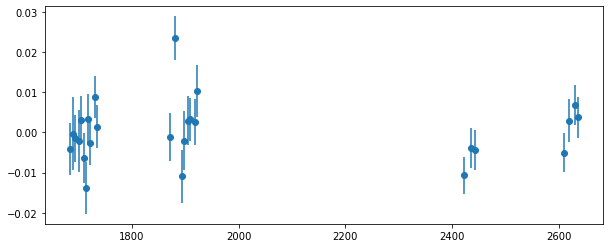

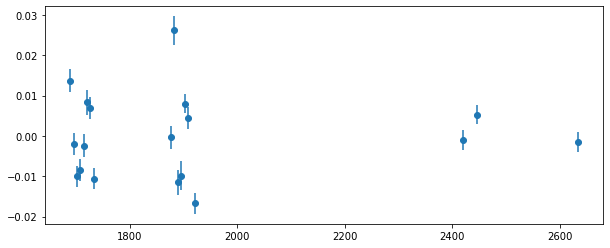

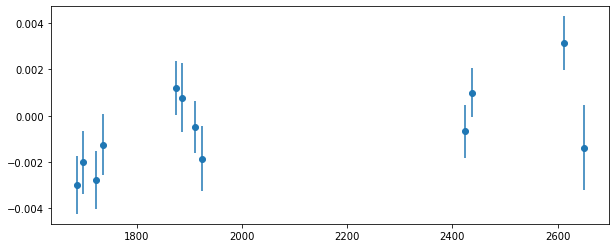

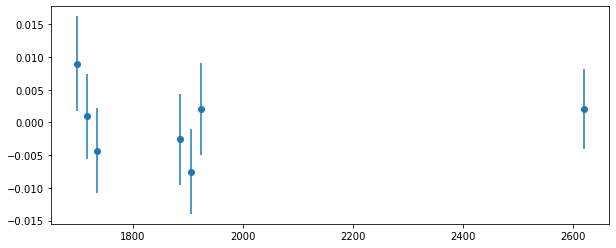

In [68]:
for j in range(4):
    plt.figure(figsize=(10,4))
    _idx = jttv.pidx==j+1
    res = jttv.tcobs_flatten[_idx]-mmodel[_idx]
    print (np.std(res), np.std(res/0.01), np.median(jttv.errorobs_flatten[_idx]), np.max(jttv.errorobs_flatten[_idx]))
    #plt.errorbar(jttv.tcobs_flatten[_idx], res/jttv.errorobs_flatten[_idx], fmt='o')
    plt.errorbar(jttv.tcobs_flatten[_idx], res, yerr=jttv.errorobs_flatten[_idx], fmt='o')

In [69]:
M_earth = 3.0034893e-6
samples['pmass'] = samples['mass'] / M_earth
keys = ['pmass', 'tic', 'period', 'ecc', 'omega']

(array([ 1.,  0.,  0.,  1.,  0.,  2.,  5., 15., 49., 27.]),
 array([-7.10076795, -6.87423995, -6.64771195, -6.42118395, -6.19465595,
        -5.96812795, -5.74159995, -5.51507195, -5.28854395, -5.06201595,
        -4.83548795]),
 <BarContainer object of 10 artists>)

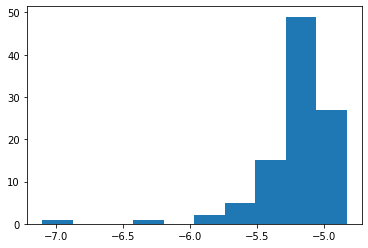

In [70]:
plt.hist(np.log10(np.abs(samples['ediff'])))

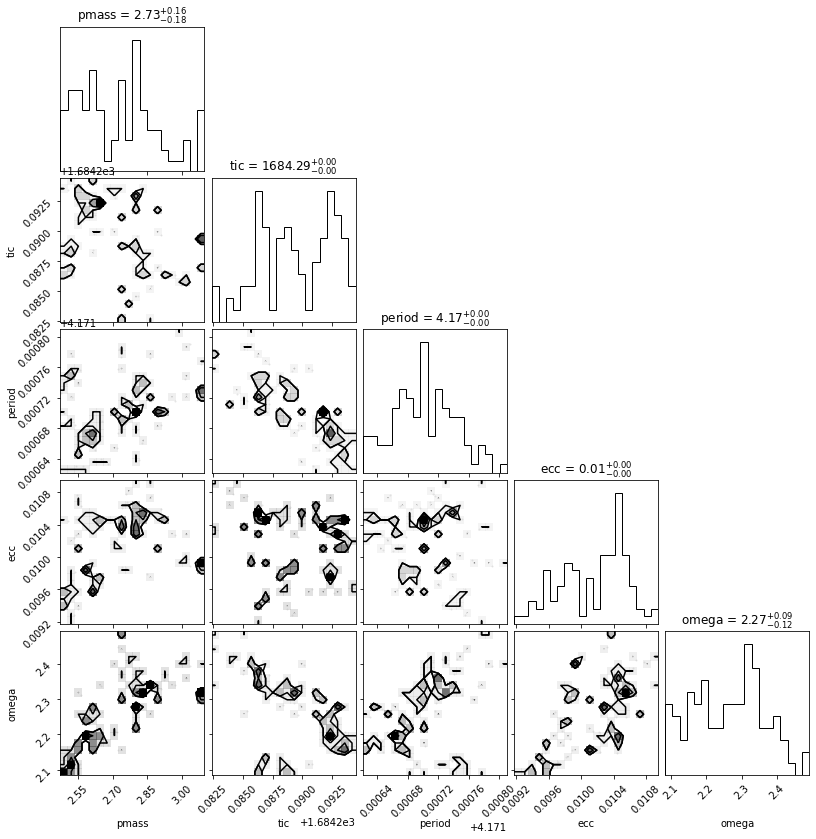

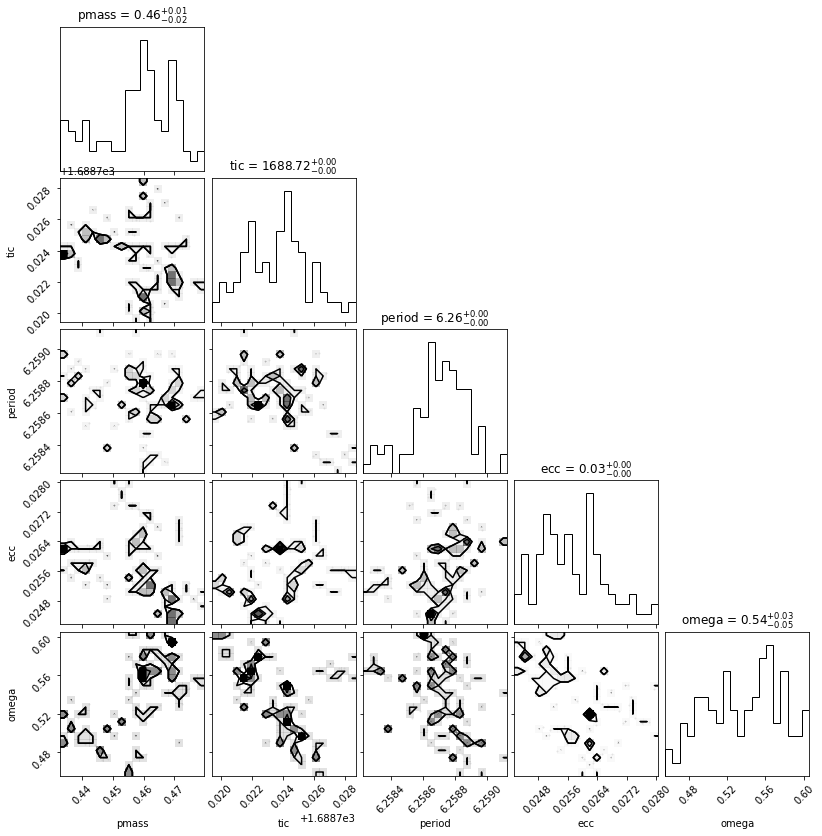

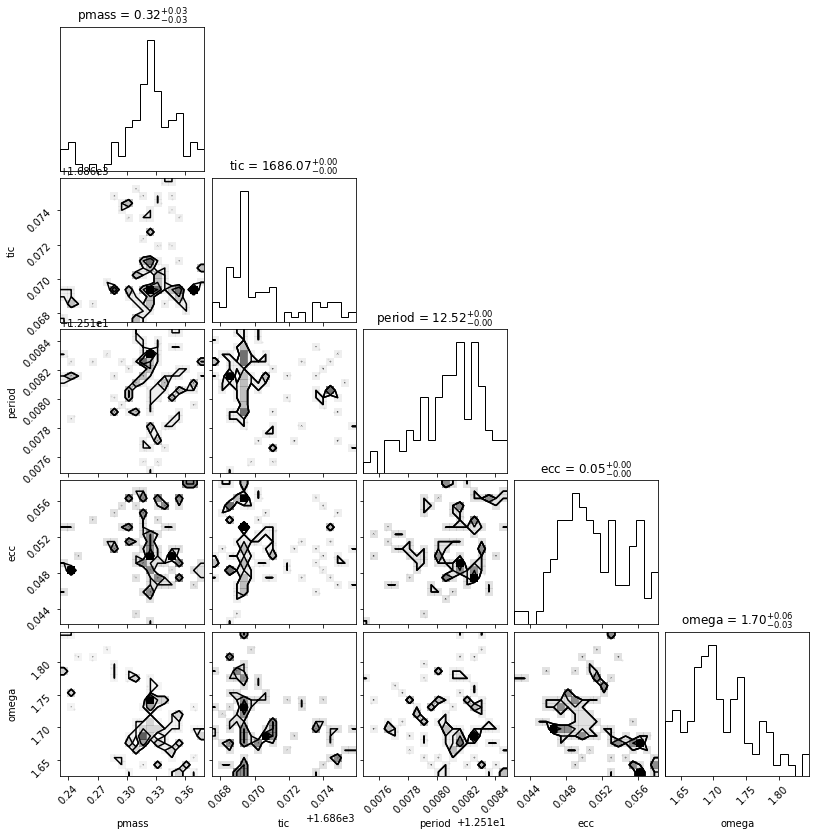

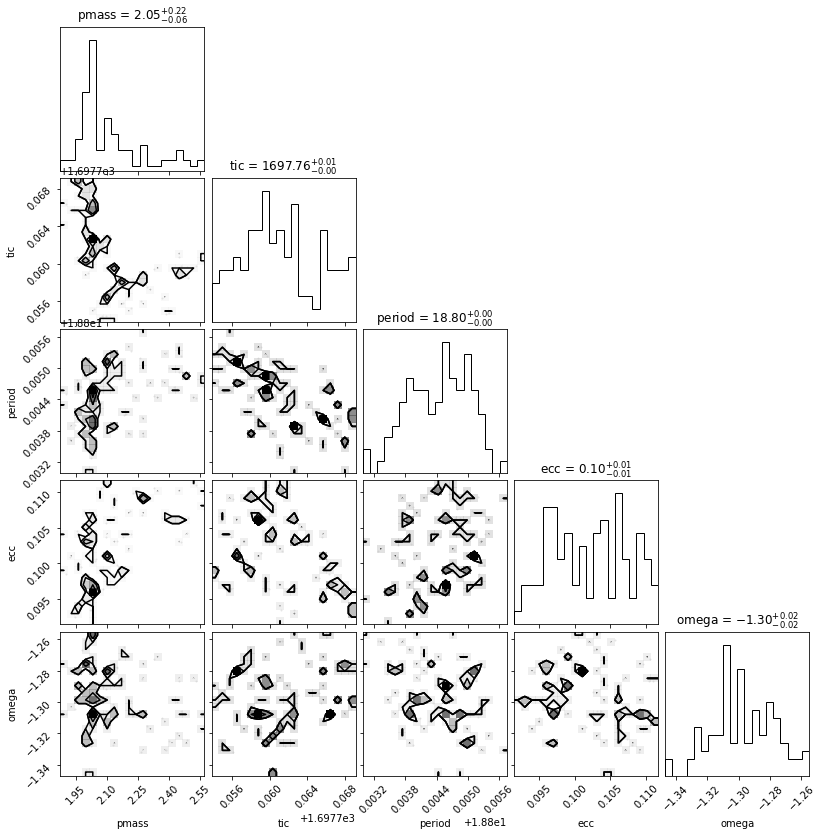

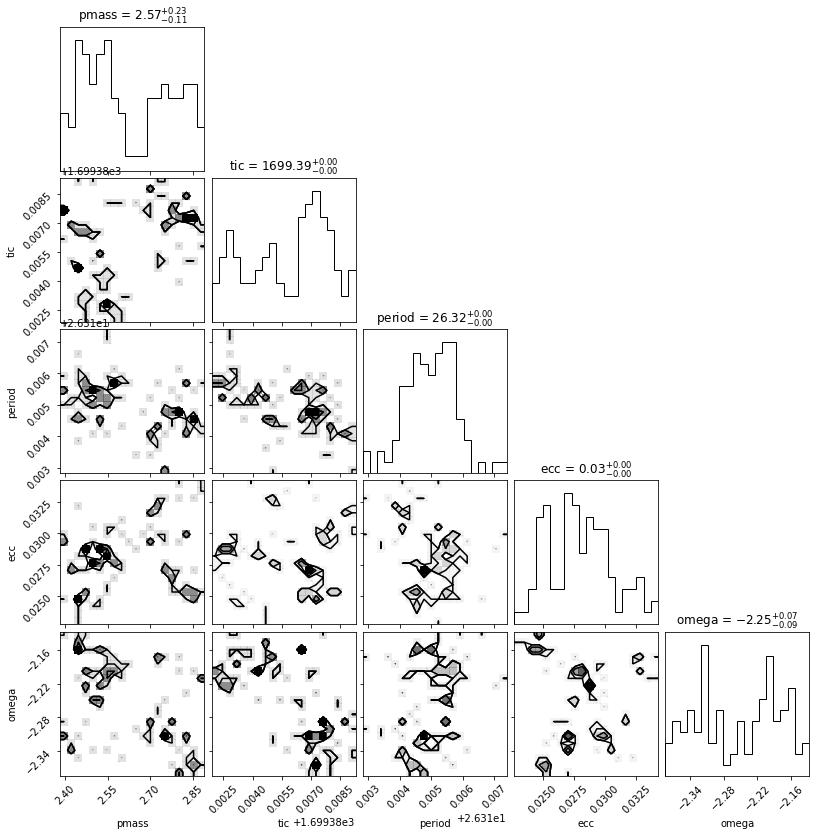

In [72]:
for j in range(jttv.nplanet):
    hyper = pd.DataFrame(data=dict(zip(keys, [samples[k][:,j] for k in keys])))
    fig = corner.corner(hyper, labels=keys, show_titles="%.2f")
    plt.savefig(outdir+"corner%d.png"%(j+1), dpi=200, bbox_inches="tight");

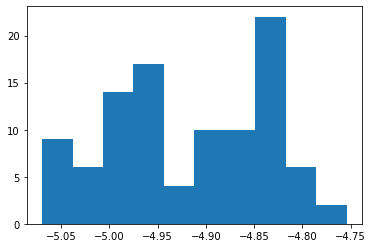

In [73]:
plt.hist(np.array(samples['lntcjitter']));